In [1]:
import numpy as np
from copy import deepcopy as copy
import tqdm
#import networkx as nx
from numba import jit, prange
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import pickle
import numba
import tensorflow
import networkx as nx
#Completer.use_jedi = False
import multiprocessing as mp


# %%
@numba.jit(nopython=True)
def relu(x):
    return max(x, 0)


@numba.jit(nopython=True)
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


@numba.jit(nopython=True)
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


class NodeGene:
    def __init__(self, id, type, h=0, bias=np.random.uniform(-1, 1)):
        self.h = h
        self.type = type
        self.id = id
        self.bias = bias


class ConnectionGene:
    def __init__(self, inputNode, outputNode, weight, innovation, enabled=True):
        self.enabled = enabled
        self.innovation = innovation
        self.weight = weight
        self.outputNode = outputNode
        self.inputNode = inputNode


class Specimen:
    # generating Phenotype from Genotype

    def __init__(self, input_, output, protection=3):
        self.id_of_next = output + input_

        inputs = [NodeGene(i, 'input') for i in range(input_)]
        outputs = [NodeGene(i + len(inputs), 'output', h=1) for i in range(output)]

        self.nodes = inputs + outputs
        self.protection = protection
        self.connections = []
        innovation = 0
        for i in range(input_):
            for j in range(input_, input_ + output):
                self.connections.append(ConnectionGene(i, j, np.random.normal(0, 1), innovation))
                innovation += 1

    def create_new(self):
        new_specimen = copy(self)
        new_specimen.protection = 3
        return new_specimen

    def forward(self, input_):

        order = [node.h for node in self.nodes]
        output = np.array([None] * (len(self.nodes) - len(input_)))
        order = np.argsort(order)
        values = [0] * len(self.nodes)
        values = np.array(values).astype('float32')
        # now we are sending the signal
        for i, node in enumerate([self.nodes[i] for i in order]):
            if node.h == 0:
                values[node.id] = input_[node.id]
                for connection in self.connections:
                    if connection.inputNode == node.id:
                        values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

            elif node.h > 0 and node.h < 1:

                for connection in self.connections:
                    values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

            elif node.h == 1:
                # this is output neuron
                output[node.id - len(input_)] = values[node.id]

        return output

    def return_with_mutated_weight(self, threshold=0.8):
        new = copy(self)
        for connection in new.connections:
            if np.random.uniform(0, 1) < threshold:
                connection.weight *= np.random.uniform(-2.5, 2.5)
            else:
                connection.weight = np.random.normal(0, 1)

        return new

    def return_with_mutated_bias(self, threshold=0.8):
        new = copy(self)
        for node in new.nodes:
            if np.random.uniform(0, 1) < threshold:
                node.bias *= np.random.uniform(-2.5, 2.5)
            else:
                node.bias = np.random.normal(0, 1)
        return new

    def accuracy(self, x, y):

        res = []
        for i in tqdm.trange(len(x)):
            res.append(np.argmax(softmax(self.forward(x[i]).astype('float32'))))

        return ((res == y) * 1).mean()

    def mae(self, x, y):
        res = []
        for inp in x:
            res.append(self.forward(inp))

        return np.abs(x - y).mean()


def forward_async(specimen: Specimen, input_):
    order = [node.h for node in specimen.nodes]
    output = np.array([None] * (len(specimen.nodes) - len(input_)))
    order = np.argsort(order)
    values = [0] * len(specimen.nodes)
    values = np.array(values).astype('float32')
    # now we are sending the signal
    for i, node in enumerate([specimen.nodes[i] for i in order]):
        if node.h == 0:
            values[node.id] = input_[node.id]
            for connection in specimen.connections:
                if connection.inputNode == node.id:
                    values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

        elif node.h > 0 and node.h < 1:

            for connection in specimen.connections:
                values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

        elif node.h == 1:
            # this is output neuron
            output[node.id - len(input_)] = values[node.id]

    return output


def global_accuracy(specimen: Specimen, x, y):
    results = []

    res = []
    for i in tqdm.trange(len(x)):
        res.append(np.argmax(softmax(specimen.forward(x[i]).astype('float32'))))

    return ((res == y) * 1).mean()

class NEAT:

    def __init__(self, population_number, input_, output):
        self.population_number = population_number
        self.input = input_
        self.output = output
        self.innovation = input_ * output
        self.connection_innovations = []
        self.gen_mean = []

    def start(self):
        # initialize the population
        self.population = [Specimen(self.input, self.output) for i in range(self.population_number)]

    def calculate_innovation(self, connection_innovation):

        for nodes in self.connection_innovations:
            if nodes[0] == connection_innovation:
                k = nodes[1]
                return [k, k + 1]

        # if there was no innovation like this before, than:
        self.connection_innovations.append([connection_innovation, self.innovation])
        p = self.innovation
        self.innovation += 2

        return [p, p + 1]

    def add_connection(self, network):
        new_network = copy(network)
        a, b = np.random.choice(network.nodes, 2, replace=False)
        does_exist = False

        # first search for connection in genes
        for connection in new_network.connections:
            if a.id == connection.inputNode and b.id == connection.outputNode:
                does_exist = True
        if a.type != b.type:
            if not does_exist:
                if a.h < b.h:
                    new_network.connections.append(
                        ConnectionGene(a.id, b.id, np.random.normal(0, 1.5), self.innovation))
                else:
                    new_network.connections.append(
                        ConnectionGene(b.id, a.id, np.random.normal(0, 1.5), self.innovation))
                self.innovation += 1
        return new_network

    @staticmethod
    def find_connection_by_innovation(specimen, innovation):
        for connection in specimen.connections:
            if connection.innovation == innovation:
                return connection

    def cross(self, a, b):

        child = Specimen(0, 0)
        if len(a.nodes) > len(b.nodes):
            child.nodes = a.nodes
        else:
            child.nodes = b.nodes

        a_innovations = [x.innovation for x in a.connections]
        b_innovations = [x.innovation for x in b.connections]

        for innovation_number in range(max(a_innovations) + max(b_innovations) + 1):
            if innovation_number in a_innovations:
                if innovation_number in b_innovations:
                    if np.random.uniform(0, 1) > 0.5:
                        new_connection = copy(self.find_connection_by_innovation(a, innovation_number))
                    else:
                        new_connection = copy(self.find_connection_by_innovation(b, innovation_number))

                    child.connections.append(new_connection)
                else:
                    new_connection = copy(self.find_connection_by_innovation(a, innovation_number))
                    child.connections.append(new_connection)
            else:
                if innovation_number in b_innovations:
                    new_connection = copy(self.find_connection_by_innovation(b, innovation_number))
                    child.connections.append(new_connection)

        return child

    def add_node(self, network):
        new_network = copy(network)
        a = new_network.connections[np.random.choice(len(new_network.connections), 1)[0]]
        if a.enabled:

            a.enabled = False
            higher_node_id = new_network.id_of_next
            new_network.id_of_next += 1

            height_input = new_network.nodes[a.inputNode].h
            height_output = new_network.nodes[a.outputNode].h
            h = np.random.uniform(0.7 * height_input + 0.3 * height_output, 0.3 * height_input + 0.7 * height_output)
            new_network.nodes.append(NodeGene(higher_node_id, 'hidden', h=h))
            innovation = self.calculate_innovation(a.innovation)

            new_network.connections.append(
                ConnectionGene(a.inputNode, higher_node_id, np.random.uniform(-1, 1), innovation[0]))
            new_network.connections.append(
                ConnectionGene(higher_node_id, a.outputNode, np.random.uniform(-1, 1), innovation[1]))
            return new_network
        else:
            return network

    def start_evolution(self, x, y, epochs=50, to_mutate=0.7, measure='acc'):
        best_specimen = None
        for i in range(epochs):
            nodes_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            nodes_to_mutate = [self.population[i].create_new() for i in nodes_to_mutate]
            spec_with_mutated_node = [self.add_node(specimen) for specimen in nodes_to_mutate]
            connection_to_mutate = np.random.choice(self.population_number,
                                                    int(np.ceil(self.population_number * to_mutate)))
            connection_to_mutate = [self.population[i].create_new() for i in connection_to_mutate]
            spec_with_mutated_connection = [self.add_connection(specimen) for specimen in connection_to_mutate]
            weight_to_mutate = np.random.choice(self.population_number,
                                                int(np.ceil(self.population_number * to_mutate)))
            weight_to_mutate = [self.population[i].create_new() for i in weight_to_mutate]
            spec_with_mutated_weight = [specimen.return_with_mutated_weight() for specimen in weight_to_mutate]
            bias_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            bias_to_mutate = [self.population[i].create_new() for i in bias_to_mutate]
            spec_with_mutated_bias = [specimen.return_with_mutated_bias() for specimen in bias_to_mutate]

            to_cross = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)),
                                        replace=False)
            spec_crossed = []
            for j in range(0, len(to_cross) - 1, 2):
                spec_crossed.append(self.cross(self.population[to_cross[j]], self.population[to_cross[j + 1]]))

            new_population = self.population + spec_with_mutated_node + spec_with_mutated_connection + spec_with_mutated_weight + spec_with_mutated_bias + spec_crossed

            pool = mp.Pool(mp.cpu_count())

            if measure == 'acc':
                metrics_for_new_population = [pool.apply(global_accuracy, args=(specimen, x, y)) for specimen in new_population]
            else:
                metrics_for_new_population = [-specimen.mae(x, y) for specimen in new_population]

            pool.close()
            best_ = np.argsort(metrics_for_new_population)
            best = best_[-self.population_number:]

            for spec in new_population:
                if spec.protection > 0:
                    self.population.append(spec)

            for j, spec in enumerate(self.population):
                spec.protection -= 1
                self.population[j] = spec

            self.population = list(np.array(new_population)[best])

            pool = mp.Pool(mp.cpu_count())
            if measure == 'acc':
                self.gen_mean.append(np.mean([pool.apply(global_accuracy, args = (specimen, x, y)) for specimen in self.population]))
                print(
                    f'iteration: {i}/{epochs}\nPopulation mean: {self.gen_mean[-1]} \nPopulation best: {np.max(metrics_for_new_population)}\n',
                    end='')

            else:
                self.gen_mean.append(np.mean([specimen.mae(x, y) for specimen in self.population]))
                print(
                    f'iteration: {i}/{epochs}\nPopulation mean: {self.gen_mean[-1]} \nPopulation best: {-np.max(metrics_for_new_population)}\n',
                    end='')

            pool.close()
        pool = mp.Pool(mp.cpu_count())
        metrics_for_new_population = [global_accuracy(specimen, x, y) for specimen in self.population]
        pool.close()
        best = np.argsort(metrics_for_new_population)
        self.best = self.population[best[-1]]

@jit(parallel=True, forceobj=True)
def process_images(data: np.array):
    ret = []
    for i in prange(len(data)):
        mat = data[i].reshape(28, 28)
        M, N = mat.shape
        K = 2
        L = 2

        MK = M // K
        NL = N // L
        p = mat[:MK * K, :NL * L].copy()
        p = p.reshape(MK, K, NL, L).copy()
        p = p.mean(axis=(1, 3)).copy()

        # once more
        mat = p
        M, N = mat.shape
        K = 2
        L = 2

        MK = M // K
        NL = N // L
        p = mat[:MK * K, :NL * L].reshape(MK, K, NL, L).max(axis=(1, 3))
        p = p[1:-1, 1:-1]

        ret.append(p.flatten())

    return np.array(ret)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

In [4]:
train_df = pd.read_csv('../data/iris.data', header=None, index_col=0).reset_index()

x = np.asarray(train_df.iloc[:,0:4])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

y = np.asarray(train_df.iloc[:,4]).reshape(-1, 1)
y = OrdinalEncoder().fit_transform(y).astype('int').flatten()


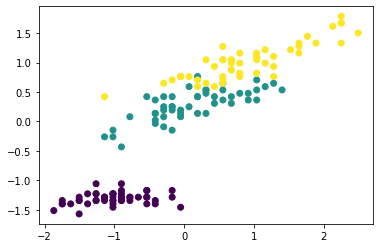

In [5]:
plt.scatter(x[:,0], x[:,2], c=y)
plt.show()

In [ ]:
neat = NEAT(100, 4, 3)
neat.start()
neat.start_evolution(x[:10], y[:10], epochs=40)

went into the thread


Text(0, 0.5, 'mean accuracy of population')

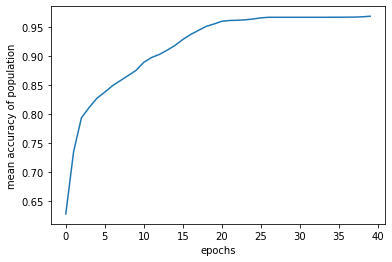

In [18]:
plt.plot(neat.gen_mean)
plt.xlabel('epochs')
plt.ylabel('mean accuracy of population')

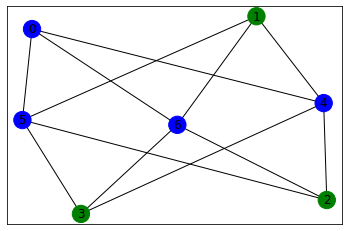

In [21]:
cons = [(neat.best.connections[i].inputNode, neat.best.connections[i].outputNode) for i in range(len(neat.best.connections))]
ids = [neat.best.nodes[i].id for i in range(len(neat.best.nodes))]

G = nx.Graph()
G.add_edges_from(cons)
color_map = []
for i, node in enumerate(G):
    if neat.best.nodes[i].type == 'input':
        color_map.append('blue')
    elif  neat.best.nodes[i].type == 'output':
        color_map.append('green')
    else: 
        color_map.append('red')
nx.draw_networkx(G, node_color= color_map)

## Adult

In [2]:
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

In [3]:
adult

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

categorical_features = [7, 8, 9]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_features = [0, 2, 4, 10, 11, 12]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

x = preprocessor.fit_transform(adult)
y = OrdinalEncoder().fit_transform(np.array(adult[14]).reshape(-1, 1)).flatten()

indices = np.random.permutation(np.arange(len(y)))
x = x[indices]
y = y[indices]

print('started training')
#neat = NEAT(100, 19, 2)
#neat.start()
#neat.start_evolution(x[:3000], y[:3000], epochs=40)

started training


Niestety tutaj z było już potrzebne zrównoleglanie i musiałem zrobić to w pycharmie. Wczytamy więc zapiklowany obiekt.

In [2]:
#neat = NEAT(100, 19, 2)
#neat.start()
#neat.start_evolution(X[:3000, :], y[:3000].flatten(), epochs=40)

In [5]:
with open('adult.pkl', 'rb') as ogorek:
    neat = pickle.load(ogorek)

Text(0, 0.5, 'mean accuracy of population')

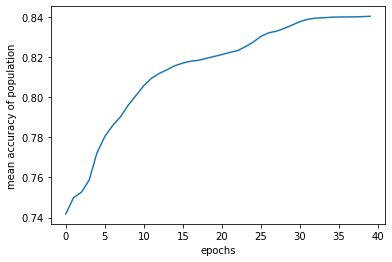

In [6]:
plt.plot(neat.gen_mean)
plt.xlabel('epochs')
plt.ylabel('mean accuracy of population')

In [7]:
neat.best.accuracy(x, y)

100%|██████████████████████████████████████████████████████████████████████████| 32561/32561 [00:10<00:00, 3061.94it/s]


0.8372592979331102

## MNIST

In [8]:
import tensorflow as tf
data = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [9]:
x = data[0][0]
y = data[0][1]
x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

x5 = x[np.where(y == 5)[0]]
y5 = y[np.where(y == 5)[0]]
xnot5 = x[np.where(y != 5)[0]]
ynot5 = y[np.where(y != 5)[0]]

indices = np.random.choice(np.arange(len(xnot5)), x5.shape[0], replace=False, )
xnot5 = xnot5[indices]
ynot5 = ynot5[indices]

x = np.append(x5, xnot5, axis=0)
y = np.append(y5, ynot5)

indices = np.random.permutation(np.arange(len(x)))
x = x[indices]
y = y[indices]

y[y != 5] = 0
y[y == 5] = 1

x = x/ 255

In [12]:
@jit(parallel=True, forceobj=True)
def process_images(data: np.array):
    ret = []
    for i in prange(len(data)):
    
        mat = data[i].reshape(28,28)
        M, N = mat.shape
        K = 2
        L = 2

        MK = M // K
        NL = N // L
        p = mat[:MK*K, :NL*L].copy()
        p = p.reshape(MK, K, NL, L).copy()
        p = p.mean(axis=(1, 3)).copy()

        # once more
        mat = p
        M, N = mat.shape
        K = 2
        L = 2

        MK = M // K
        NL = N // L
        p = mat[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))
        p = p[1:-1, 1:-1]

        ret.append(p.flatten())
    
    return np.array(ret)



Obrazek przed processingiem: 

In [19]:
import matplotlib.pyplot as plt

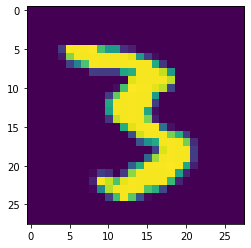

In [20]:
imgplot = plt.imshow(x[0].reshape(28, 28))
plt.show()

Obrazek po processingu:

In [13]:
x_processed = process_images(x)

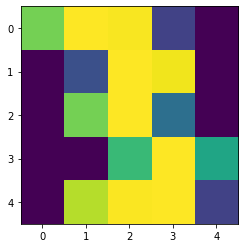

In [22]:
imgplot = plt.imshow(x_processed[0].reshape(5, 5))
plt.show()

Dzięki takiemy processingowi będziemy mieć zdecydowanie mniej wymiarów! Niestety tak samo jak wcześniej, tu też musiałem użyć zrównoleglania. Wczytamy więc zapiklowany obiekt.

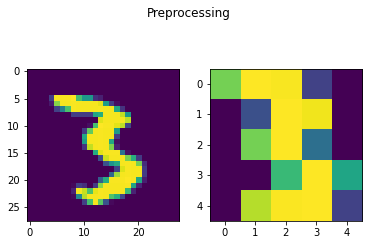

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Preprocessing')
ax1.imshow(x[0].reshape(28, 28))
ax2.imshow(x_processed[0].reshape(5, 5))

In [38]:
#neat = NEAT(10, 75, 2)
#neat.start()
#neat.start_evolution(x[:1000, :], y[:1000].flatten(), epochs=10)

In [10]:
import pickle

with open('mnist.pkl', 'rb') as FILE:
    neat = pickle.load(FILE)
    

Text(0, 0.5, 'mean accuracy of population')

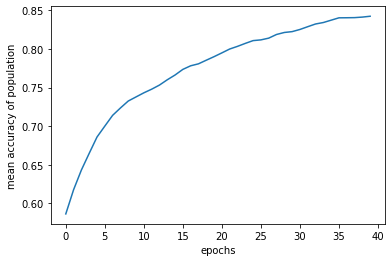

In [11]:
plt.plot(neat.gen_mean)
plt.xlabel('epochs')
plt.ylabel('mean accuracy of population')

In [14]:
neat.best.accuracy(x_processed, y)

100%|██████████████████████████████████████████████████████████████████████████| 10842/10842 [00:03<00:00, 2714.85it/s]


0.7648035417819591